<a href="https://colab.research.google.com/github/ashfak0046/Machine-Learning_Quiz/blob/main/ML_Quiz_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# ==============================================================
# Visualizing MNIST-784 with a Self-Organizing Map (SOM)
# ==============================================================

!pip install minisom --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
from minisom import MiniSom
from collections import Counter


In [25]:
# 1) Load
data, meta = arff.loadarff("/content/mnist_784.arff")
df = pd.DataFrame(data)

# features = first 784 columns, label = last column
X = df.iloc[:, :-1].to_numpy(dtype=float)
y = df.iloc[:, -1].astype(str).astype(int).to_numpy()   # <-- ensure NumPy array

print("shape:", X.shape, "| labels:", np.unique(y))


shape: (70000, 784) | labels: [0 1 2 3 4 5 6 7 8 9]


In [26]:
# 2) Normalize + subsample for speed
X = X / 255.0
n_samples = 5000
rng = np.random.default_rng(42)
idx = rng.choice(X.shape[0], n_samples, replace=False)
X_sub, y_sub = X[idx], y[idx]   # <-- y_sub is NumPy
print("training on:", X_sub.shape)

training on: (5000, 784)


In [27]:
# 3) Train SOM (20x20 grid)
som_size = 20
som = MiniSom(x=som_size, y=som_size, input_len=X_sub.shape[1],
              sigma=1.0, learning_rate=0.5, random_seed=42)

som.random_weights_init(X_sub)
print("training SOM...")
som.train_random(X_sub, num_iteration=2000, verbose=True)
print("done.")

training SOM...
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 4.949814665618926
done.


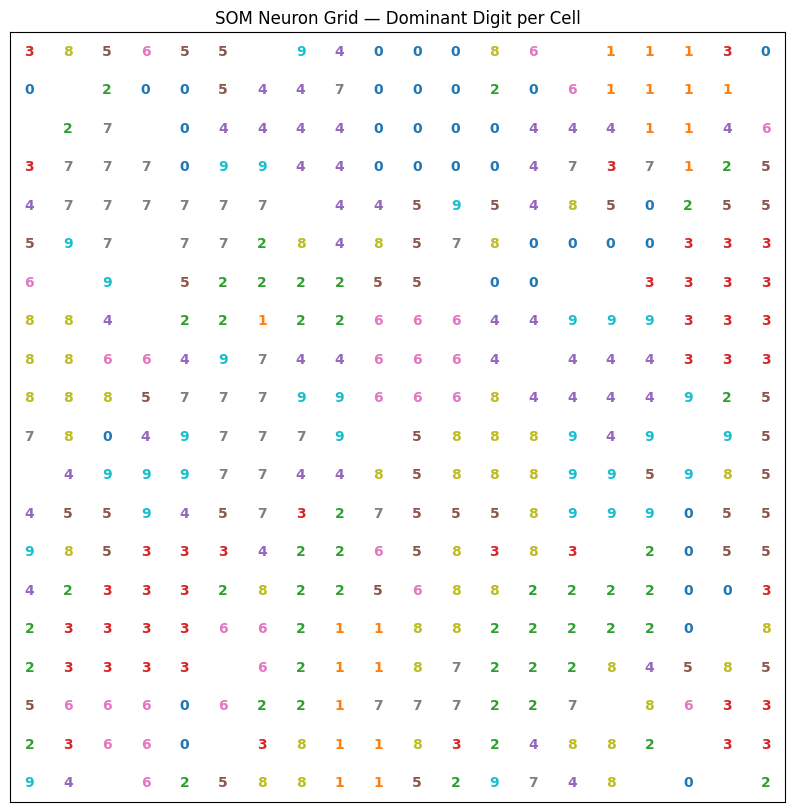

In [28]:
# 4a) Dominant-digit grid
label_map = {}
for i, sample in enumerate(X_sub):
    row, col = som.winner(sample)  # (row, col)
    label_map.setdefault((row, col), []).append(int(y_sub[i]))

plt.figure(figsize=(10,10))
for (row, col), labels in label_map.items():
    counts = Counter(labels)
    label = max(counts, key=counts.get)
    plt.text(col + 0.5, row + 0.5, str(label),
             color=plt.cm.tab10(label/10),
             ha='center', va='center', fontsize=10, fontweight='bold')

plt.xlim([0, som_size]); plt.ylim([0, som_size])
plt.gca().invert_yaxis()
plt.title("SOM Neuron Grid — Dominant Digit per Cell")
plt.xticks([]); plt.yticks([])
plt.show()

### SOM Grid Findings
The 20×20 neuron grid shows that the SOM managed to organize digits into coherent regions.  
Digits with similar shapes are placed close to each other: for example, 0s and 9s cluster on the right side, while 3s dominate a separate area on the left.  
Some neighboring cells share mixed digits such as 4 and 9 or 3 and 5 — which makes sense because those digits have overlapping strokes.  
The overall pattern looks consistent: clear dominant zones with gradual transitions at their borders, which confirms that the SOM preserved topological relationships between digit patterns.


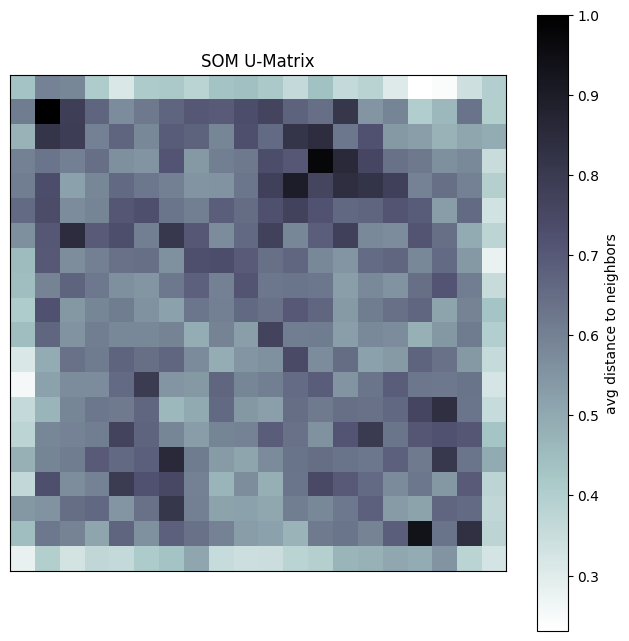

In [29]:
# 4b) U-Matrix
u = som.distance_map()
plt.figure(figsize=(8,8))
plt.imshow(u, cmap="bone_r", origin="upper")
plt.colorbar(label="avg distance to neighbors")
plt.title("SOM U-Matrix")
plt.xticks([]); plt.yticks([])
plt.show()

### U-Matrix Interpretation
The U-Matrix shows average distances between neighboring neurons.  
Dark blocks correspond to high distances, indicating boundaries between clusters, while lighter areas mark regions of similar neuron weights.  
Here, the darker edges separate major digit groups — roughly matching the zones seen in the label grid.  
This confirms that the SOM has formed several well-defined clusters in the high-dimensional MNIST space and projected them onto a 2-D map while keeping nearby digits close.


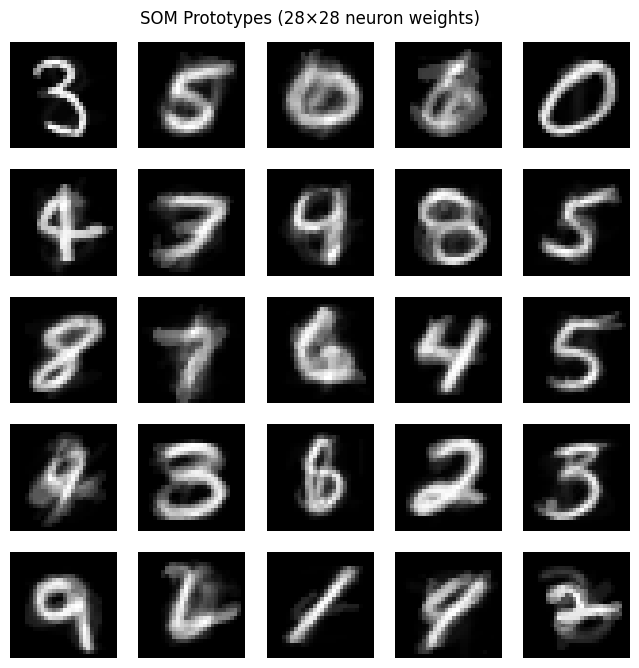

In [30]:
# 4c) Prototype neurons (28x28)
W = som.get_weights()  # (som_size, som_size, 784)
fig, axes = plt.subplots(5, 5, figsize=(8,8))
pick_rows = np.linspace(0, som_size-1, 5, dtype=int)
pick_cols = np.linspace(0, som_size-1, 5, dtype=int)
for i, r in enumerate(pick_rows):
    for j, c in enumerate(pick_cols):
        axes[i, j].imshow(W[r, c].reshape(28,28), cmap="gray")
        axes[i, j].axis("off")
plt.suptitle("SOM Prototypes (28×28 neuron weights)", y=0.92)
plt.show()

### Prototype Visualization
Each neuron’s weight vector can be reshaped into a 28×28 image to show what pattern that neuron represents.  
Most prototypes clearly resemble real digits — for example, distinct 0s, 3s, 4s, 7s, and 9s appear across the grid.  
A few prototypes look blurred where multiple digits overlapped during training, but overall they capture the key stroke structure of each class.  
This demonstrates that the SOM learned meaningful visual features from the raw pixel data, producing human-interpretable “average digits” for different parts of the map.
